In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

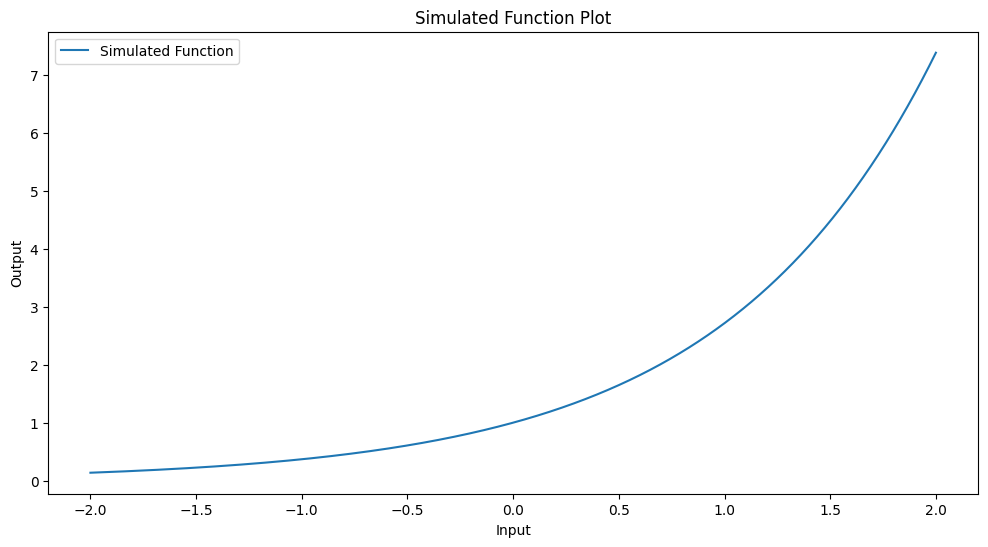

In [2]:
# Function
def simulate_function(x):
    return np.exp(x)

# Generate training data as tensors
x_train = torch.tensor(np.expand_dims(np.arange(-3, 3, 0.001), 1), dtype=torch.float32)
y_train = torch.tensor(simulate_function(x_train), dtype=torch.float32)

# Generate validation data as tensors
x_val = torch.tensor(np.linspace(-2, 2, 2000).reshape(2000, 1), dtype=torch.float32)
y_val = torch.tensor(simulate_function(x_val), dtype=torch.float32)

# Plot the validation data
plt.figure(figsize=(12, 6))
plt.plot(x_val, y_val, label='Simulated Function')
plt.title('Simulated Function Plot')
plt.xlabel('Input')
plt.ylabel('Output')
plt.legend()
plt.show()

In [3]:
class Model(nn.Module):
    def __init__(self,):
        super(Model, self).__init__()
    
        self.input_layer = nn.Linear(1, 12)
        
        self.hidden_layers = nn.ModuleList([
            nn.Linear(12, 10),
            nn.Linear(10, 18),
            nn.Linear(18, 8),
            nn.Linear(8, 6),
            nn.Linear(6, 5)
        ])
        
        
        self.output_layer = nn.Linear(5, 1)
        
        
    def forward(self, x):
        x = self.input_layer(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        
        for hidden_layer in self.hidden_layers:
            x = hidden_layer(x)
            x = F.leaky_relu(x, negative_slope=0.2)
        
        output = self.output_layer(x)
        return output

model = Model()

optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)
loss_function = torch.nn.MSELoss()

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear_1 = nn.Linear(1, 4)
        self.linear_2 = nn.Linear(4, 9)
        self.linear_3 = nn.Linear(9, 12)
        self.linear_6 = nn.Linear(10, 10)
        self.linear_7 = nn.Linear(10, 4)
        self.predict = nn.Linear(4, 1)

    def forward(self,x):
        x = nn.functional.leaky_relu(self.linear_1(x))
        x = nn.functional.leaky_relu(self.linear_2(x))
        x = nn.functional.leaky_relu(self.linear_3(x))
        x = nn.functional.leaky_relu(self.linear_4(x))
        x = nn.functional.leaky_relu(self.linear_5(x))
        x = nn.functional.leaky_relu(self.linear_6(x))
        x = nn.functional.leaky_relu(self.linear_7(x))

        x = self.predict(x)
        return x

In [5]:
def compute_grad_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        grad = 0.0
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy()**2).sum()
        grad_all += grad
    return grad_all ** 0.5

In [6]:
def log_epoch_status(epoch, loss, interval=50):
    if epoch % interval == 0:
        print(f'Epoch: {epoch}, Loss = {loss:.4f}')

In [7]:
def update_loss_grad_arrays(loss, grad_norm, losses, grad_arr):
    losses.append(loss.detach().numpy())
    grad_arr.append(grad_norm)

In [8]:
def compute_hessian_and_min_ratio(model, loss, total_params):
    H = torch.zeros((total_params, total_params))

    Jacob = torch.autograd.grad(loss, list(model.parameters()), create_graph=True)
    Jacob = torch.cat([e.flatten() for e in Jacob])
    
    for i in range(total_params):
        result = torch.autograd.grad(Jacob[i], list(model.parameters()), retain_graph=True)
        H[i] = torch.cat([r.flatten() for r in result])

    H_eig = torch.symeig(H).eigenvalues
    positive_count = sum(1 for eig in H_eig.tolist() if eig > 0)
    min_ratio = positive_count / H.shape[0]
    
    return min_ratio

In [9]:
def check_gradient_norm(grad_norm, threshold=0.001):
    return grad_norm < threshold

In [10]:
def compute_loss(model, x_train, y_train):
    optimizer.zero_grad()
    outputs = model(x_train)
    loss = loss_function(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    return loss

In [11]:
def train_epoch(model, optimizer, x_train, y_train):
    loss = compute_loss(model, x_train, y_train)
    grad_norm = compute_grad_norm(model)
    
    return loss, grad_norm

In [12]:
def train_model(model, optimizer, x_train, y_train, epochs=1000, tolerance=1e-5):
    model.train()
    losses, grad_arr, epoch_arr = [], [], []
    loss_m_val = 0.001
    min_ratio = 0.001

    for epoch in range(epochs):
        epoch_arr.append(epoch)

        loss, grad_norm = train_epoch(model, optimizer, x_train, y_train)
        update_loss_grad_arrays(loss, grad_norm, losses, grad_arr)
        
        log_epoch_status(epoch, loss.item())

        total_params = sum(p.numel() for p in model.parameters())
        if check_gradient_norm(grad_norm):
            print('Gradient norm reached minimum value')
            loss_m = loss_function(model(x_train), y_train)
            min_ratio = compute_hessian_and_min_ratio(model, loss_m, total_params)
            print('Minimal Ratio: ', min_ratio, ', Loss: ', loss_m_val, ', Epoch: ', epoch)
            loss_m_val = loss_m.data.detach().numpy()
            break

    return loss_m_val, min_ratio


In [13]:
losses = []
min_ratios = []
for index in range(100):
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr = 1e-3)

    loss_value, min_ratio = train_model(model,optimizer, x_train, y_train)
    losses.append(loss_value)
    min_ratios.append(min_ratio)

Epoch: 0, Loss = 33.5618
Epoch: 50, Loss = 31.2752
Epoch: 100, Loss = 29.5218
Epoch: 150, Loss = 28.0996
Epoch: 200, Loss = 26.9203
Epoch: 250, Loss = 25.9282
Epoch: 300, Loss = 25.0874
Epoch: 350, Loss = 24.3763
Epoch: 400, Loss = 23.7818
Epoch: 450, Loss = 23.2804
Epoch: 500, Loss = 22.8484
Epoch: 550, Loss = 22.4594
Epoch: 600, Loss = 22.0685
Epoch: 650, Loss = 21.4940
Epoch: 700, Loss = 20.2590
Epoch: 750, Loss = 15.6087
Epoch: 800, Loss = 7.5617
Epoch: 850, Loss = 4.8474
Epoch: 900, Loss = 3.0250
Epoch: 950, Loss = 1.9122
Epoch: 0, Loss = 1.2154
Epoch: 50, Loss = 0.8340
Epoch: 100, Loss = 0.6562
Epoch: 150, Loss = 0.5817
Epoch: 200, Loss = 0.5498
Epoch: 250, Loss = 0.5334
Epoch: 300, Loss = 0.5227
Epoch: 350, Loss = 0.5145
Epoch: 400, Loss = 0.5075
Epoch: 450, Loss = 0.5012
Epoch: 500, Loss = 0.4953
Epoch: 550, Loss = 0.4898
Epoch: 600, Loss = 0.4845
Epoch: 650, Loss = 0.4795
Epoch: 700, Loss = 0.4747
Epoch: 750, Loss = 0.4700
Epoch: 800, Loss = 0.4654
Epoch: 850, Loss = 0.4609
Ep

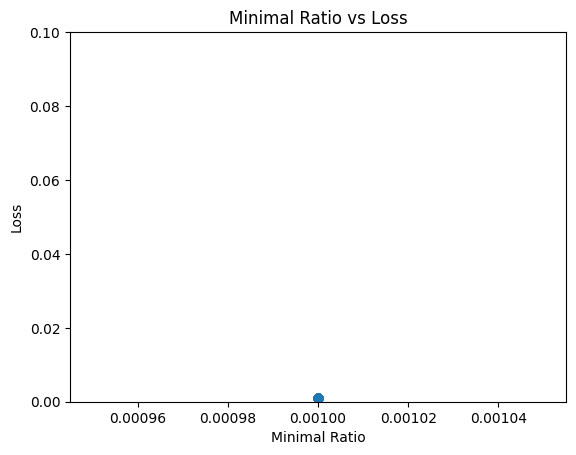

In [14]:
plt.figure()
plt.plot(min_ratios, losses, marker='o')
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')
plt.ylim(0, 0.1)
plt.title('Minimal Ratio vs Loss')
plt.show()